The traveling salesman problem (TSP) is a famous NP hard problem in computer science. The problem might be summarized as follows: imagine you are a salesperson who needs to visit some number of cities. Because you want to minimize costs spent on traveling (or maybe you're just lazy like I am), you want to find out the most efficient route, one that will require the least amount of traveling. You are given a coordinate of the cities to visit on a map. How can you find the optimal route?

The most obvious solution would be the brute force method, where you consider all the different possibilities, calculate the estimated distance for each, and choose the one that is the shortest path. While this is a definite way to solve TSP, the issue with this approach is that it requires a lot of compute---the runtime of this brute force algorithm would be $O(n!)$, which is just utterly terrible. 

In this post, we will consider a more interesting way to approach TSP: genetic algorithms. As the name implies, genetic algorithms somewhat simulate an evolutionary process, in which the principle of the survival of the fittest ensures that only the best genes will have survived after some iteration of evolutionary cycles across a number of generations. Genetic algorithms can be considered as a sort of randomized algorithm where we use random sampling to ensure that we probe the entire search space while trying to find the optimal solution. While genetic algorithms are not the most efficient or guaranteed method of solving TSP, I thought it was a fascinating approach nonetheless, so here goes the post on TSP and genetic algorithms. 

# Problem and Setup

Before we dive into the solution, we need to first consider how we might represent this problem in code. Let's take a look at the modules we will be using and the mode of representation we will adopt in approaching TSP.

## Setup

Below are the modules we will be using for this post. We will be using `numpy`, more specifically a lot of functions from `numpy.random` for things like sampling, choosing, or permuting. `numpy` arrays are also generally faster than using normal Python lists since they support vectorization, which will certainly be beneficial when building our model. For reproducability, let's set the random seed to 42.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")
np.random.seed(42)

## Representation

Now we need to consider the question of how we might represent TSP in code. Obviously, we will need some cities and some information on the distance between these cities. 

One solution is to consider adjacency matrices, somewhat similar to the adjacency list we took a look at on the post on Breadth First and Depth First Search algorithms. The simple idea is that we can construct some matrix that represent distances between cities $i$ and $j$ such that $A_{ij}$ represents the distance between those two cities. When $i=j$, therefore, it is obvious that $A_{ii}$ will be zero, since the distance from city $i$ to itself is trivially zero.

Here is an example of some adjacency matrix. For convenience purposes, we will represent cities by their indices. 

In [2]:
cities = [0, 1, 2, 3, 4]

adjacency_mat = np.asarray(
    [
        [0.00, 28.02, 17.12, 27.46, 46.07],
        [28.02, 0.00, 34.00, 25.55, 25.55],
        [17.12, 34.00, 0.00, 18.03, 57.38],
        [27.46, 25.55, 18.03, 0.00, 51.11],
        [46.07, 25.55, 57.38, 51.11, 0.00],
    ]
)

# Genetic Algorithm

Now it's time for us to understand how genetic algorithms work. Don't worry, you don't have to be a biology major to understand this; simple intuition will do. 

## Concept

The idea is that, we can use some sort of randomized approach to generate an initial population, and motivate an evolutionary cycle such that only superior genes will survive successive iterations. You might be wondering what genes are in this context. Most typically, genes can be thought of as some representation of the solution we are trying to find. In this case, an encoding of the optimal path would be the gene we are looking for. 

Evolution is a process that finds an optimal solution for survival through competition and mutation. Basically, the genes that have superior traits will survive, leaving offspring into the next generation. Those that are inferior will be unable to find a mate and perish, as sad as it sounds. Then how do these superior or inferior traits occur in the first place? The answer lies in random mutations. The children of one parent will not all have identical genes: due to mutation, which occurs by chance, some will acquire even more superior features that puts them far ahead of their peers. Needless to say, such beneficiaries of positive mutation will survive and leave offspring, carrying onto the next generation. Those who experience adversarial mutation, on the other hand, will not be able to survive. 

In genetic algorithm engieering, we want to be able to simulate this process over an extended period of time without hard-coding our solution, such that the end result after hundred or thousands of generations will contain the optimal solution. Of course, we can't let the computer do everything: we still have to implement mutational procedures that define an evolutionary process. But more on that later. First, let's begin with the simple task of building a way of modeling a population. 

## Implementation

First, let's define a class to represent the population. I decided to go with a class-based implementation to attach pieces of information about a specific generation of population to that class object. Specifically, we can have things like `bag` to represent the full population, `parents` to represent th chosen, selected superior few, `score` to store the score of the best chromosome in the population, `best` to store the best chromosome itself, and `adjacency_mat`, the adjacency matrix that we will be using to calculate the distance in the context of TSP. 

In [3]:
class Population():
    def __init__(self, bag, adjacency_mat):
        self.bag = bag
        self.parents = []
        self.score = 0
        self.best = None
        self.adjacency_mat = adjacency_mat

Here is a little snippet of code that we will be using to randomly generate the first generation of population. 

In [4]:
def init_population(cities, adjacency_mat, n_population):
    return Population(
        np.asarray([np.random.permutation(cities) for _ in range(n_population)]), 
        adjacency_mat
    )

Let's see if this everything works as expected by generating a dummy population.

In [5]:
pop = init_population(cities, adjacency_mat, 5)
pop.bag

array([[1, 4, 2, 0, 3],
       [3, 1, 2, 0, 4],
       [1, 0, 3, 4, 2],
       [0, 1, 2, 3, 4],
       [0, 2, 3, 1, 4]])

Now we need some function that will determine the fitness of a chromosome. In the context of TSP, fitness is defined in very simple terms: the shorter the total distance, the fitter and more superior the chromosome. Recall that all the distance information we need is nicely stored in `self.adjacency_mat`. We can calculate the sum of all the distances between two adjacent cities in the chromosome sequence.

In [6]:
def fitness(self, chromosome):
    return sum(
        [
            self.adjacency_mat[chromosome[i], chromosome[i + 1]]
            for i in range(len(chromosome) - 1)
        ]
    )

Population.fitness = fitness

Next, we evaluate the population. Simply put, evaluation amounts to calculating the fitness of each chromosome in the total population, determining who is best, storing the score information, and returning some probability vector whose each element represents the probability that the `i`th element in the population bag is chosen as a parent. We apply some basic preprocessing to ensure that the worst performing chromosome has absolutely no chance of being selected. 

In [7]:
def evaluate(self):
    distances = np.asarray(
        [self.fitness(chromosome) for chromosome in self.bag]
    )
    self.score = np.min(distances)
    self.best = self.bag[distances.tolist().index(self.score)]
    self.parents.append(self.best)
    if False in (distances[0] == distances):
        distances = np.max(distances) - distances
    return distances / np.sum(distances)
    
Population.evaluate = evaluate

When we call `pop.evaluate()`, we get a probability vector as expected. From the result, it appears that the last element is the best chromosome; the second chromosome in the population bag is the worst.

In [8]:
pop.evaluate()

array([0.19370949, 0.21905217, 0.        , 0.17431729, 0.41292105])

When we call `pop.best`, notice that we get the last element in the population, as previously anticipated.

In [9]:
pop.best

array([0, 2, 3, 1, 4])

We can also access the score of the best chromosome. In this case, the distance is said to be 86.25. Note that the lower the score, the better, since these scores represent the total distance a salesman has to travel to visit all the cities.

In [10]:
pop.score

86.25

Now, we will select `k` number of parents to be the basis of the next generation. Here, we use a simple roulette model, where we compare the value of the probability vector and a random number sampled from a uniform distribution. If the value of the probability vector is higher, the corresponding chromosome is added to `self.parents`. We repeat this process until we have `k` parents.

In [11]:
def select(self, k=4):
    fit = self.evaluate()
    while len(self.parents) < k:
        idx = np.random.randint(0, len(fit))
        if fit[idx] > np.random.rand():
            self.parents.append(self.bag[idx])
    self.parents = np.asarray(self.parents)

Population.select = select

As expected, we get 4 parents after selecting the parents through `pop.select()`. 

In [12]:
pop.select()
pop.parents

array([[0, 2, 3, 1, 4],
       [0, 2, 3, 1, 4],
       [3, 1, 2, 0, 4],
       [0, 1, 2, 3, 4]])

Now is the crucial part: mutation. There are different types of mutation schemes we can use for our model. Here, we use a simple swap and crossover mutation. As the name implies, swap simply involves swapping two elements of a chromosome. For instance, if we have `[a, b, c]`, we might swap the first two elements to end up with `[b, a, c]`.

In [13]:
def swap(chromosome):
    a, b = np.random.choice(len(chromosome), 2)
    chromosome[a], chromosome[b] = (
        chromosome[b],
        chromosome[a],
    )
    return chromosome

The problem with swap mutation, however, is the fact that swapping is a very disruptive process in the context of TSP. Because each chromosome encodes the order in which a salesman has to visit each city, swapping two cities may greatly impact the final fitness score of that mutated chromosome. 

Therefore, we also use another form of mutation, known as crossovers. In crossover mutation, we grab two parents. Then, we slice a portion of the chromosome of one parent, and fill the rest of the slots with that of the other parent. When filling the rest of the slots, we need to make sure that there are no duplicates in the chromosome. Let's take a look at an example. Imagine one parent has `[a, b, c, d, e]` and the other has `[b, a, e, c, d]`. Let's also say that slicing a random portion of the first parent gave us `[None, b, c, None, None]`. Then, we fill up the rest of the empty indices with the other parent, paying attention to the order in which elements occur. In this case, we would end up with `[a, b, c, e, d]`. Let's see how this works. 

In [14]:
def crossover(self, p_cross=0.1):
    children = []
    count, size = self.parents.shape
    for _ in range(len(self.bag)):
        if np.random.rand() > p_cross:
            children.append(
                list(self.parents[np.random.randint(count, size=1)[0]])
            )
        else:
            parent1, parent2 = self.parents[
                np.random.randint(count, size=2), :
            ]
            idx = np.random.choice(range(size), size=2, replace=False)
            start, end = min(idx), max(idx)
            child = [None] * size
            for i in range(start, end + 1, 1):
                child[i] = parent1[i]
            pointer = 0
            for i in range(size):
                if child[i] is None:
                    while parent2[pointer] in child:
                        pointer += 1
                    child[i] = parent2[pointer]
            children.append(child)
    return children

Population.crossover = crossover

Now, we wrap the swap and crossover mutation into one nice function to call so that we perform each mutation according to some specified threshoold. 

In [15]:
def mutate(self, p_cross=0.1, p_mut=0.1):
    next_bag = []
    children = self.crossover(p_cross)
    for child in children:
        if np.random.rand() < p_mut:
            next_bag.append(swap(child))
        else:
            next_bag.append(child)
    return next_bag
    
Population.mutate = mutate

Let's test it on `pop`. When we call `pop.mutate()`, we end up with the population bag for the next generation, as expected.

In [16]:
pop.mutate()

[[3, 1, 2, 0, 4],
 [0, 1, 2, 3, 4],
 [3, 1, 4, 0, 2],
 [3, 1, 2, 0, 4],
 [3, 1, 2, 0, 4]]

Now it's finally time to put it all together. For convenience, I've added some additional parameters such as `print_interval` or `verbose`, but for the most part, a lot of what is being done here should be familiar and straightforward. The gist of it is that we run a simulation of population selection and mutation over `n_iter` generations. The key part is `children = pop.mutate(p_cross, p_mut)` and `pop = Population(children, pop.adjacency_mat)`. Basically, we obtain the children from the mutation and pass it over as the population bag of the next generation in the `Population` constructor. 

In [17]:
def genetic_algorithm(
    cities,
    adjacency_mat,
    n_population=5,
    n_iter=20,
    selectivity=0.15,
    p_cross=0.5,
    p_mut=0.1,
    print_interval=100,
    return_history=False,
    verbose=False,
):
    pop = init_population(cities, adjacency_mat, n_population)
    best = pop.best
    score = float("inf")
    history = []
    for i in range(n_iter):
        pop.select(n_population * selectivity)
        history.append(pop.score)
        if verbose:
            print(f"Generation {i}: {pop.score}")
        elif i % print_interval == 0:
            print(f"Generation {i}: {pop.score}")
        if pop.score < score:
            best = pop.best
            score = pop.score
        children = pop.mutate(p_cross, p_mut)
        pop = Population(children, pop.adjacency_mat)
    if return_history:
        return best, history
    return best

Now let's test it on our TSP example over 20 generations. As generations pass, the fitness score seems to improve, but not by a lot.

In [18]:
genetic_algorithm(cities, adjacency_mat, verbose=True)

Generation 0: 105.04
Generation 1: 105.04
Generation 2: 104.13
Generation 3: 104.13
Generation 4: 104.13
Generation 5: 104.13
Generation 6: 104.13
Generation 7: 104.13
Generation 8: 104.13
Generation 9: 104.13
Generation 10: 104.13
Generation 11: 104.13
Generation 12: 104.13
Generation 13: 104.13
Generation 14: 104.13
Generation 15: 104.13
Generation 16: 104.13
Generation 17: 104.13
Generation 18: 104.13
Generation 19: 104.13


[3, 0, 2, 1, 4]

Let's try running this over an extended period of time, namely 100 generations. For clarity, let's also plot the progress of our genetic algorithm by setting `return_history` to `True`. 

Generation 0: 117.11000000000001
Generation 20: 99.06
Generation 40: 86.25
Generation 60: 86.25
Generation 80: 86.25


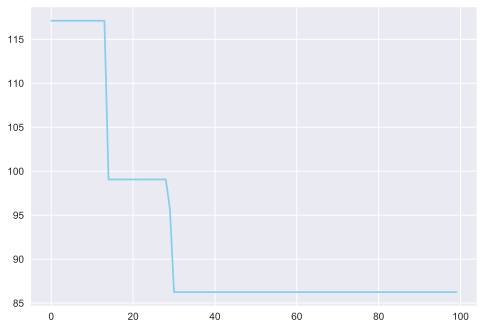

[4, 1, 3, 2, 0]


In [19]:
best, history = genetic_algorithm(
    cities,
    adjacency_mat,
    n_iter=100,
    verbose=False,
    print_interval=20,
    return_history=True,
)

plt.plot(range(len(history)), history, color="skyblue")
plt.show()
print(best)

After something like 30 iterations, it seems like algorithm has converged to the minimum, sitting at around 86.25. Apparently, the best way to travel the cities is to go in the order of `[4, 1, 3, 2, 0]`. 

# Example Applications

But this was more of a contrieved example. We want to see if this algorithm can scale. So let's write some functions to generate city coordinates and corresponding adjacency matrices.

In [20]:
def generate_cities(n_cities, factor=10):
    return np.random.rand(n_cities, 2) * n_cities * factor

`generate_cities()` generates `n_cities` number of random city coordinates in the form of a numpy array. Now, we need some functions that will create an adjancency matrix based on the city coordinates.

In [21]:
def make_mat(coordinates):
    res = [
        [get_distance(city1, city2) for city2 in coordinates]
        for city1 in coordinates
    ]
    return np.asarray(res)

def get_distance(city1, city2):
    return np.sqrt((city1[0] - city2[0])**2 + (city1[1] - city2[1])**2)

Let's perform a quick sanity check to see if `make_mat()` works as expected. Here, give vertices of a unit square as input to the function. While we're at it, let's also make sure that `generate_cities()` indeed does create city coordinates as expected.

In [22]:
test_coords = [[0, 0], [0, 1], [1, 1], [1, 0]]

make_mat(test_coords)

array([[0.        , 1.        , 1.41421356, 1.        ],
       [1.        , 0.        , 1.        , 1.41421356],
       [1.41421356, 1.        , 0.        , 1.        ],
       [1.        , 1.41421356, 1.        , 0.        ]])

In [23]:
generate_cities(5)

array([[26.00952616, 22.38014702],
       [27.8910096 ,  8.30171567],
       [30.67365693, 18.15503683],
       [44.85931705,  8.44271033],
       [25.35255519, 29.90563147]])

Now, we're finally ready to use these functions to randomly generate city coordinates and use the genetic algorithm to find the optimal path using `genetic_algorithm()` with the appropriate parameters. Let's run the algorithm for a few iterations and plot its history.

Generation 0: 50574.20948201705
Generation 100: 37016.74080507189
Generation 200: 29461.92301346868
Generation 300: 27377.57152367764
Generation 400: 25832.95851026539
Generation 500: 24982.527095698166
Generation 600: 23996.17871767765
Generation 700: 23747.520578015312
Generation 800: 22876.05723826875
Generation 900: 22585.508967184436


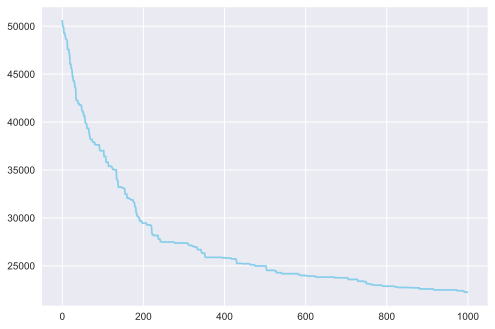

[91, 82, 25, 69, 52, 78, 2, 57, 75, 29, 27, 81, 35, 92, 18, 68, 34, 79, 58, 55, 0, 54, 74, 13, 37, 23, 67, 19, 61, 97, 64, 86, 93, 65, 17, 1, 3, 8, 59, 7, 98, 66, 49, 22, 5, 62, 41, 96, 12, 95, 36, 44, 77, 48, 31, 16, 39, 99, 53, 6, 43, 42, 83, 73, 60, 71, 76, 14, 33, 89, 38, 47, 28, 9, 85, 11, 72, 21, 88, 51, 63, 4, 15, 70, 56, 24, 94, 87, 90, 80, 50, 26, 30, 10, 40, 84, 46, 32, 20, 45]


In [24]:
cities = range(100)
city_coordinates = generate_cities(len(cities))
adjacency_mat = make_mat(city_coordinates)
best, history = genetic_algorithm(
    cities, adjacency_mat, n_population=20, n_iter=1000, verbose=False, return_history=True
)
plt.plot(range(len(history)), history, color="skyblue")
plt.show()
print(best)

We can see that the genetic algorithm does seems to be optimizing the path as we expect, since the distance metric seems to be decreasing throughout the iteration. Now, let's actually try plotting the path along with the corresponding city coordinates. Here's a helper function to print the optimate path.

In [25]:
def print_path(best, city_coordinates):
    points = city_coordinates[best]
    x, y = zip(*points)
    plt.plot(x, y, color="skyblue", marker="o")

And calling this function, we obtain the following:

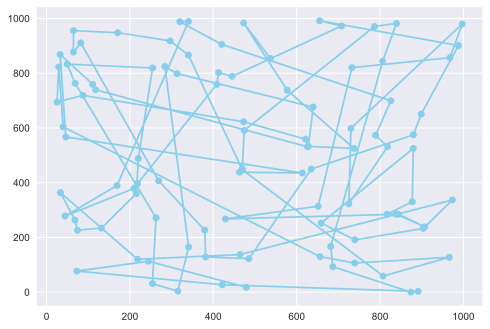

In [26]:
print_path(best, city_coordinates)

At a glance, it's really difficult to see if this is indeed the optimal path, especially because the city coordinates were generated at random. 

I therefore decided to create a much more contrieved example, but with many coordinates, so that we can easily verify whether the path decided on by the algorithm is indeed the optimal path. Namely, we will be arranging city coordinates to lie on a semi-circle, using the very familiar equation 

$$
y^2 = \sqrt{r^2 - x^2}
$$

In [27]:
def better_generate_cities(n_cities, factor=0.2):
    x = np.asarray(range(int(-n_cities / 2), int(n_cities / 2) + 1, 1))
    y = np.sqrt(n_cities ** 2 / 4 - x ** 2)
    return np.asarray(list(zip(x, y)))

Let's create 100 such fake cities and run the genetic algorithm to optimize the path. If the algorithm does successfully find an optimal path, it will be a single curve from one end of the semi-circle fully connected all the way up to its other end. 

Generation 0: 2964.489767366144
Generation 500: 871.7211766732178
Generation 1000: 688.4158889546616
Generation 1500: 600.4773168672432
Generation 2000: 531.3472866075754
Generation 2500: 502.99936690851723
Generation 3000: 418.2191546248274
Generation 3500: 414.9874637897337
Generation 4000: 411.94420801395387
Generation 4500: 411.87289018133225
Generation 5000: 407.6196328244909
Generation 5500: 407.54195052584106


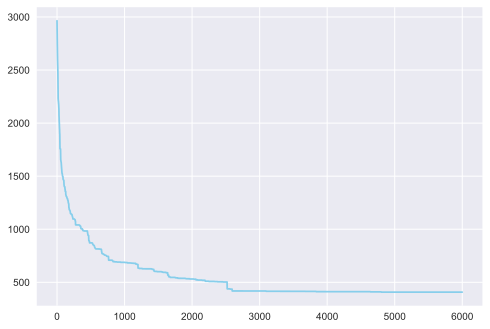

[0, 1, 2, 3, 4, 36, 37, 38, 39, 40, 41, 42, 43, 47, 48, 49, 50, 51, 52, 53, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 54, 55, 56, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 46, 45, 44, 11, 10, 9, 8, 7, 6, 5]


In [28]:
cities = range(100)
city_coordinates = better_generate_cities(len(cities))
adjacency_mat = make_mat(city_coordinates)
best, history = genetic_algorithm(
    cities, adjacency_mat, n_population=500, selectivity=0.05,
    p_mut=0.05, p_cross=0.7, n_iter=6000, print_interval=500, verbose=False, return_history=True
)
plt.plot(range(len(history)), history, color="skyblue")
plt.show()
print(best)

The algorithm seems to have converged, but the returned `best` does not seem to be the optimal path, as it is not a sorted array from 0 to 99 as we expect. Plotting this result, the fact that the algorithm hasn't quite found the most optimal solution becomes clearer. This point notwithstanding, it is still worth noting that the algorithm has found what might be referred to as optimal segments: notice that there are some segments of the path that contain consecutive numbers, which is what we would expect to see in the optimal path.

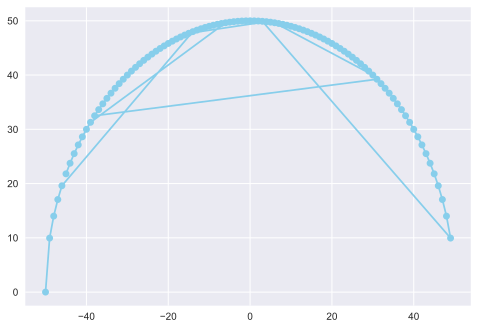

In [29]:
print_path(best, city_coordinates)

An optimal path would look as follows.

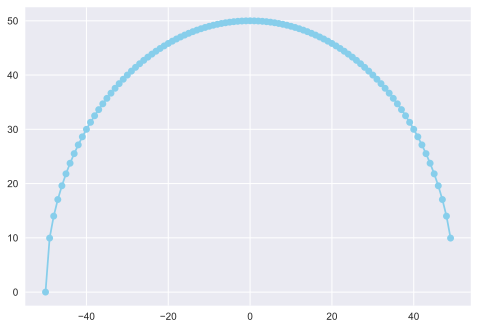

In [30]:
print_path(sorted(best), city_coordinates)

Comparing the two, we see that the optimal path returned by the genetic algorithm does contain some wasted traveling routes, namely the the chords between certain non-adjacent cities. Nonetheless, a lot of the adjacent cities are connected (hence the use of the aforementioned term, optimal segments). Considering the fact that there are a total of $100!$ possibilites, the fact that the algorithm was able to narrow it down to a plausible route that beats the baseline is still very interesting.

# Conclusion

Genetic algorithms belong to a larger group of algorithms known as randomized algorithms. Prior to learning about genetic algorithms, the word "randomized algorithms" seemed more like a mysterious black box. After all, how can an algorithm find an answer to a problem using pseudo-random number generators, for instance? This post was a great opportunity to think more about this naive question through a concrete exampe. Moreover, it was also interesting to think about the traveilng salesman problem, which is a problem that appears so simple and easy, belying the true level of difficulty under the surface. 

There are many other ways to approach TSP, and genetic algorithms are just one of the many approaches we can take. It is also not the most effective way, as iterating over generations and generations can often take a lot of time. The contrieved semi-circle example, for instance, took somewhere around five to ten minutes to fully run on my 13-inch MacBook Pro. Nonetheless, I think it is an interesting way well worth the time and effort spent on implementation. 

I hope you've enjoyed reading this post. Catch you up in the next one!